In [2]:
import polaris as po
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
# from stepmix.stepmix import StepMix
import datamol as dm
import numpy as np
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from pathlib import Path

/Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
competition = po.load_competition(f"asap-discovery/antiviral-admet-2025")
data_dir = competition.cache()

[2025-02-09 20:54:14] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=197522;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=668080;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.8).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=479925;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=489307;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

/Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[20:54:15] Copying to destination                                                                      ]8;id=221610;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=860295;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#380\380]8;;\
           /Users/robertarbon/Library/Caches/polaris/datasets/5efac7fe-8431-4439-847f-592a63bcfe46/dat             
           a.zarr                                                                                                  

           For large Zarr archives, this may take a while.                                             ]8;id=636264;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=794055;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#381\381]8;;\

[20:54:16]  Success: Copying Zarr keys                                                                ]8;id=913959;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=841147;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=719360;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=361561;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

In [4]:
random_state = 3948729

In [5]:
train, test = competition.get_train_test_split()
cols = list(competition.target_cols)
data = train.as_dataframe()

In [6]:
class YTransform:
    def __init__(self):
        self.scaler = sk.preprocessing.MinMaxScaler(feature_range=(1, 100))
        self.cols = ['MLM', 'HLM', 'D', 'KSOL', 'MDR1-MDCKII']
        self.missing_ix_by_col = {}

    def fit(self,df_train_Y):
        Y = self._col_select(df_train_Y)
        self.scaler.fit(Y)

    
    def _col_select(self, Y):
        Y['D'] = np.exp(Y['LogD'])
        return Y.loc[:,self.cols].values

    def transform(self, df_Y): 
        Y = self._col_select(df_Y)
        df = pd.DataFrame(np.log(self.scaler.transform(Y)), columns=self.cols)
        return df
    
    def inverse_transform(self, trans_Y, col):
        shape= (trans_Y.shape[0], len(self.cols))
        ix = np.where(np.array(self.cols)==col)[0]


        df = pd.DataFrame(np.zeros(shape), columns=self.cols)
        df[col] = trans_Y
        Y =  self.scaler.inverse_transform(np.exp(df.values))
        
        return pd.DataFrame({col: Y[:, ix].flatten()})
        
    
    def not_nan(self, X, df_Y, col):
        ix = ~df_Y[col].isna()
        
        return X[ix, :], df_Y.loc[ix, col].values
        

    
class FPTransform:
    def __init__(self):
        self.fps = None
        self.fps_std = None
        self.std_to_ix = {} 

    def fit(self, X): 
        self.fps = self._fps(X)
        self.fps_std = np.std(self.fps,axis=0)

    def _fps(self, X):
        return np.array([dm.to_fp(dm.to_mol(smi)) for smi in X.CXSMILES])

    def transform(self, X, std_cutoff=0): 
        informative_ix = np.where(self.fps_std > std_cutoff )[0]
        fps = self._fps(X)
        self.std_to_ix[std_cutoff] = informative_ix
        return fps[:, informative_ix]




In [43]:

model_n = 2
cutoff = 0.4

train, test = train_test_split(data, random_state=random_state)

xtrans = FPTransform()
xtrans.fit(train)
train_X = xtrans.transform(train, std_cutoff=cutoff)
test_X = xtrans.transform(test, std_cutoff=cutoff)

ytrans = YTransform()
ytrans.fit(train)
train_Y_df = ytrans.transform(train)
test_Y_df = ytrans.transform(test)


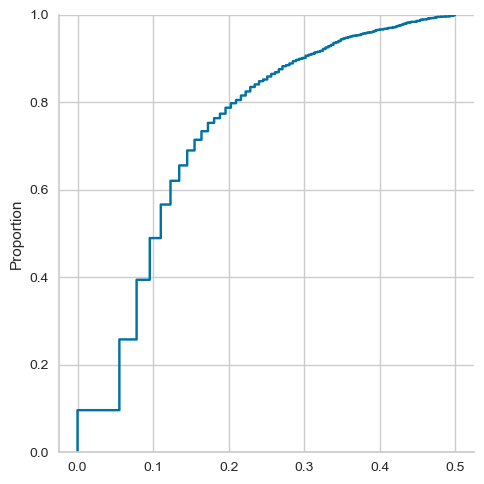

In [44]:
sns.displot(xtrans.fps_std, kind='ecdf')

In [45]:
all_results = []
all_scaled = []
score_by_target = {}
for target in ytrans.cols:



    target_dir = (Path(f'model_0{model_n}'))
    target_dir.mkdir(exist_ok=True, parents=True)


    # for col in ytrans.cols:
    model = HistGradientBoostingRegressor(random_state=random_state)

    train_X_target, train_Y_target = ytrans.not_nan(train_X, train_Y_df, col=target)
    test_X_target, test_Y_target = ytrans.not_nan(test_X, test_Y_df, col=target)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

    visualizer = ResidualsPlot(model, qqplot=True, hist=False, ax=axes[0])
    visualizer.fit(train_X_target, train_Y_target)
    visualizer.score(test_X_target, test_Y_target)
    test_Y_hat = visualizer.predict(test_X_target)

    visualizer.finalize()

    predictions = PredictionError(visualizer.estimator, ax=axes[1])
    score = predictions.score(test_X_target, test_Y_target)
    predictions.finalize()
    plt.tight_layout()
    plt.savefig(f"{target_dir}/{target}_model.png")
    plt.close()
    
    df = pd.DataFrame({'y': ytrans.inverse_transform(test_Y_target, col=target).values.flatten(),
                       'y_hat': ytrans.inverse_transform(test_Y_hat, col=target).values.flatten()}
                      )
    df2 = pd.DataFrame({'y':test_Y_target, 'y_hat': test_Y_hat })
    df2['scaled_target'] = target
    all_scaled.append(df2)

    df['target'] = target
    all_results.append(df)
    score_by_target[target] = score

df2 = pd.concat(all_scaled, axis=0)
df = pd.concat(all_results, axis=0)

df.to_csv(f"{target_dir}/predictions.csv", index=False)
df2.to_csv(f"{target_dir}/predictions_scaled.csv", index=False)


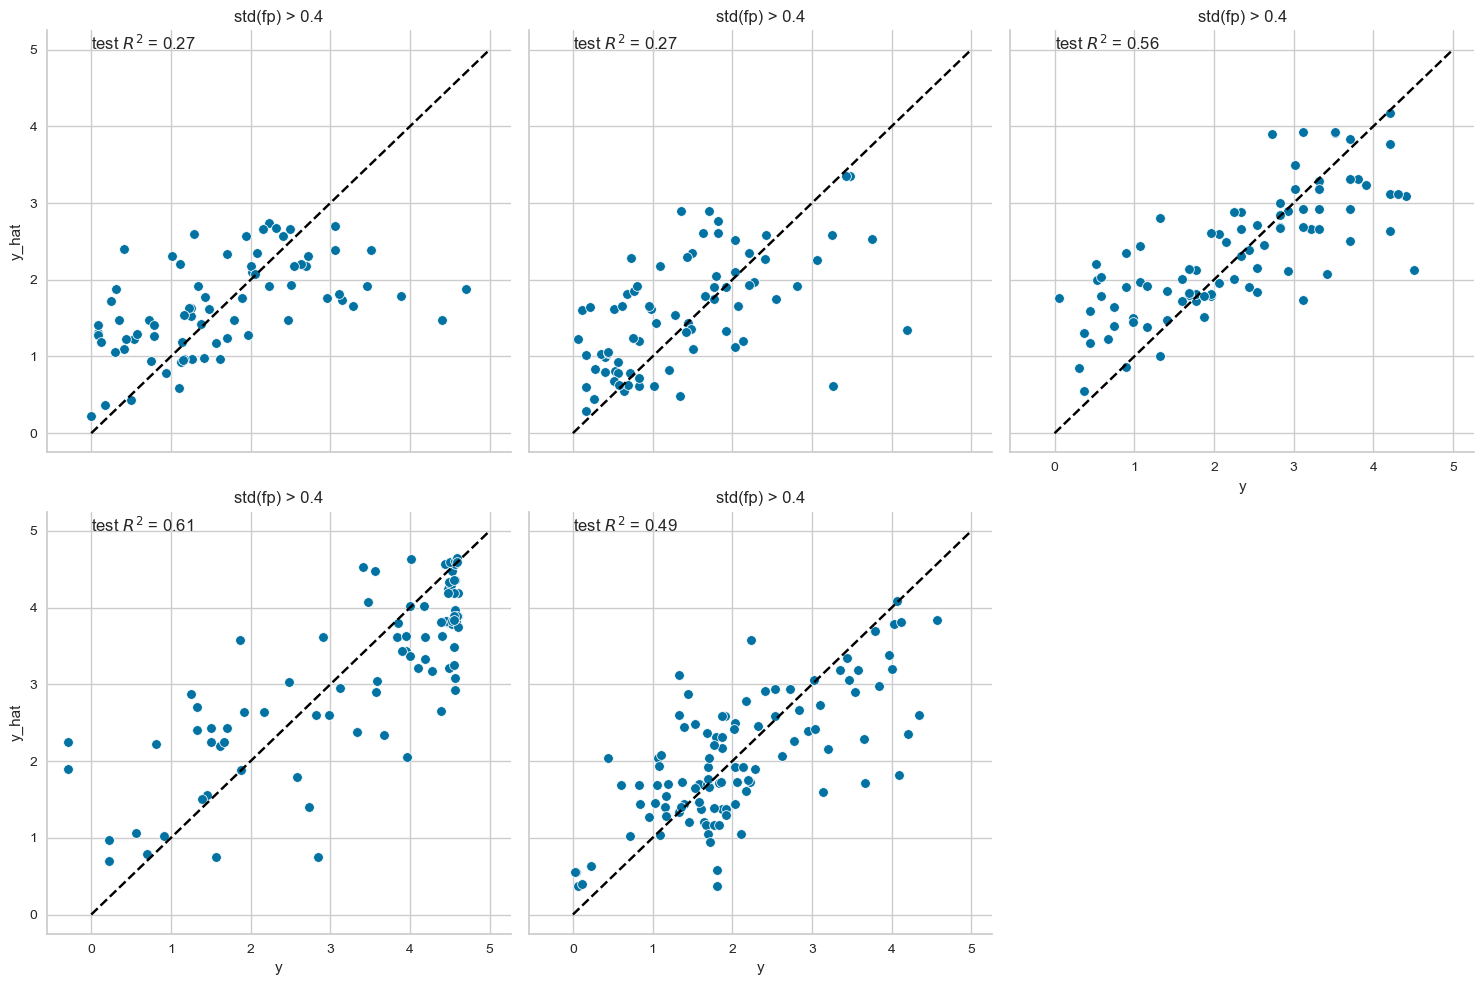

In [46]:

df2 = pd.read_csv(f'model_0{model_n}/predictions_scaled.csv')

g = sns.relplot(df2, x='y', y='y_hat', col='scaled_target', col_wrap=3)
for target, axes in g.axes_dict.items():
    axes.plot([0, 5], [0, 5], color='black', ls='--')
    axes.annotate(f"test $R^2$ = {score_by_target[target]:4.2f}", xy=(0, 5))
g.set(**dict(title=f'std(fp) > {cutoff}'))
plt.savefig(f'model_0{model_n}/results.png', bbox_inches='tight')